In [1]:
!pip install -q scikit-multilearn

try:
  %tensorflow_version 2.x
except Exception:
  print('Ahem! Ahem! Not in CoLab.')

TensorFlow 2.x selected.


In [2]:
!git clone https://git.cse.iitb.ac.in/ssood/posters-dataset.git

fatal: destination path 'posters-dataset' already exists and is not an empty directory.


In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import random
import os
import cv2
import gc

import time
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline


In [4]:
print(tf.__version__)

# Prints something if GPU is connected
tf.test.gpu_device_name()
tf.random.set_seed(7)

2.0.0


In [5]:
!pip3 install bpmll
from bpmll import bp_mll_loss

In [0]:
# ------ Control Center ------
path = 'posters-dataset/'
poster_shape = (268, 182, 3)
year = 1989
others_genres_flag = False
num_posters = None # None for all images

batch_size = 200 
epochs = 10
train = True # True or False. False loads the model file.
bp_mll = False
english_only = True

In [0]:
genres_list = [
    "Adventure",
    "Fantasy",
    "Animation",
    "Drama",
    "Horror",
    "Action",
    "Comedy",
    "History",
    "Western",
    "Thriller",
    "Crime",
    "Documentary",
    "Science Fiction",
    "Mystery",
    "Music",
    "Romance",
    "Family",
    "War",
    "Foreign",
    "TV Movie",
]
others_label = 99999

In [0]:
def preprocess(filename, max_rows=None):
    df = pd.read_csv(filename, dtype={'imdb_id': 'str', 'genres': 'str', 'release_date': 'str', 'original_language': 'str'}, 
                     usecols=['imdb_id', 'genres', 'release_date', 'original_language'])
    
    if english_only:
      df = df[df.original_language=='en']

    # filter out all rows having no IMDB id
    # filter out all rows having no genre information
    df = df[(~df['imdb_id'].isna()) & (df['genres'] != '[]') & (~df['release_date'].isna())]
       
    # filer row with release_date > year threshold and take 'imdb_id', 'genres' columns
    df = df[df['release_date'].str[:4].astype('int16') > year][['imdb_id', 'genres']]

    X_data = []
    genre_data = []

    i = 0
    for index, row in df.iterrows():
        if i == max_rows: break
        if i % 1000 == 0 and i != 0: print(f'Loaded {i} images') 
        file = path + row['imdb_id'] + '.jpg'

        if os.path.exists(file):
            poster = cv2.imread(file)
            if poster.shape == poster_shape:
                if others_genres_flag:
                    genres = {genre['name'] if genre['name'] in genres_list else others_label for genre in eval(row['genres'])}
                else:
                    genres = {genre['name'] for genre in eval(row['genres']) if genre['name'] in genres_list}
                if genres:
                    X_data.append(poster)
                    genre_data.append(genres)
                    i += 1
            else:
                print('Problem with file:' + file)

    X_data = np.array(X_data, dtype=np.uint8)

    genre_labels = genres_list
    if others_genres_flag:
        genre_labels.append(others_label)
    mlb = MultiLabelBinarizer(classes=genre_labels)
    Y_data = mlb.fit_transform(genre_data).astype(np.float32)
    
    return X_data, Y_data

In [9]:
X_data, Y_data = preprocess('posters-dataset/movies_metadata.csv', num_posters)
X = {}
Y = {}
X['train_org'], Y['train_org'], X['test_org'], Y['test_org'] = iterative_train_test_split(X_data, Y_data, test_size = 0.15)
X['train_org'], Y['train_org'], X['val_org'], Y['val_org'] = iterative_train_test_split(X['train_org'], Y['train_org'], test_size = 0.20)

Loaded 1000 images
Loaded 2000 images
Loaded 3000 images
Loaded 4000 images
Loaded 5000 images
Loaded 6000 images
Loaded 7000 images
Loaded 8000 images
Problem with file:posters-dataset/tt1354556.jpg
Loaded 9000 images
Loaded 10000 images
Loaded 11000 images
Loaded 12000 images
Problem with file:posters-dataset/tt1534017.jpg
Loaded 13000 images
Loaded 14000 images
Loaded 15000 images
Problem with file:posters-dataset/tt1789697.jpg
Loaded 16000 images
Loaded 17000 images
Loaded 18000 images


In [0]:
X_train_temp = vgg19.preprocess_input(X['train_org'])
X_test_temp = vgg19.preprocess_input(X['test_org'])
X_val_temp = vgg19.preprocess_input(X['val_org'])

In [11]:
#'''
feature_extractor = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=poster_shape)
feature_extractor.summary()
#'''

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 268, 182, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 268, 182, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 268, 182, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 134, 91, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 134, 91, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 134, 91, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 67, 45, 128)       0     

In [12]:
#'''
start = time.time()
X['train_features'] = feature_extractor.predict(X_train_temp)
X['test_features'] = feature_extractor.predict(X_test_temp)
X['val_features'] = feature_extractor.predict(X_val_temp)
end = time.time()
print(f'Time Elapsed: {timedelta(seconds=end-start)}')
#'''

Time Elapsed: 0:12:46.698333


In [13]:
'''
feature_extractor = vgg19.VGG19(weights='imagenet', include_top=True)
feature_extractor = Model(inputs=feature_extractor.input, outputs=feature_extractor.layers[-3].output)
X['train_features'] = feature_extractor.predict(X_train_temp)
X['test_features'] = feature_extractor.predict(X_test_temp)
'''

"\nfeature_extractor = vgg19.VGG19(weights='imagenet', include_top=True)\nfeature_extractor = Model(inputs=feature_extractor.input, outputs=feature_extractor.layers[-3].output)\nX['train_features'] = feature_extractor.predict(X_train_temp)\nX['test_features'] = feature_extractor.predict(X_test_temp)\n"

In [0]:
start = time.time()
X['train_flat_features'] = X['train_features'].reshape(X['train_features'].shape[0], -1)
X['test_flat_features'] = X['test_features'].reshape(X['test_features'].shape[0], -1)
X['val_flat_features'] = X['val_features'].reshape(X['val_features'].shape[0], -1)

In [0]:
model_seq = Sequential()
model_seq.add(Dense(5000, input_dim=X['train_flat_features'].shape[1], activation='relu'))
model_seq.add(Dropout(0.3))
model_seq.add(Dense(1500, activation='relu'))
model_seq.add(Dense(500, activation='relu'))
model_seq.add(Dropout(0.3))
model_seq.add(Dense(Y['train_org'].shape[1], activation='sigmoid'))

In [0]:
if bp_mll:
  print('Zero rows?')
  print(np.where(~Y['train_org'].any(axis=1))[0])
  print(np.where(~Y['test_org'].any(axis=1))[0])
  model_seq.compile(optimizer='adagrad', loss=bp_mll_loss, metrics=['accuracy'])
else:
  model_seq.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['accuracy', 'categorical_accuracy'])


In [113]:
history = None
if train:
  start = time.time()
  history = model_seq.fit(X['train_flat_features'], Y['train_org'], 
                          batch_size=batch_size, epochs=epochs,
                          shuffle=True, 
                          validation_data=(X['val_flat_features'], Y['val_org']))
  model_seq.save('VGGN19_v1.h5', overwrite=True)
  end = time.time()
  print(f'Training Time: {timedelta(seconds=end-start)}')
else:
  model_seq = tf.keras.models.load_model('VGGN19_v1.h5')

Train on 12834 samples, validate on 3252 samples
Epoch 1/10
12834/12834 [==============================] - 15s 1ms/sample - loss: 1.9868 - accuracy: 0.8647 - categorical_accuracy: 0.2392 - val_loss: 0.2811 - val_accuracy: 0.8974 - val_categorical_accuracy: 0.3979
Epoch 2/10
12834/12834 [==============================] - 14s 1ms/sample - loss: 0.2852 - accuracy: 0.8954 - categorical_accuracy: 0.3499 - val_loss: 0.2711 - val_accuracy: 0.8990 - val_categorical_accuracy: 0.3641
Epoch 3/10
12834/12834 [==============================] - 14s 1ms/sample - loss: 0.2524 - accuracy: 0.9052 - categorical_accuracy: 0.4079 - val_loss: 0.2705 - val_accuracy: 0.8989 - val_categorical_accuracy: 0.3954
Epoch 4/10
12834/12834 [==============================] - 15s 1ms/sample - loss: 0.2237 - accuracy: 0.9152 - categorical_accuracy: 0.4768 - val_loss: 0.2757 - val_accuracy: 0.8989 - val_categorical_accuracy: 0.3792
Epoch 5/10
12834/12834 [==============================] - 14s 1ms/sample - loss: 0.1987 - a

In [0]:
predictions = {}
predictions['train'] = model_seq.predict(np.array(X['train_flat_features'], dtype=np.float32))
predictions['test'] = model_seq.predict(np.array(X['test_flat_features'], dtype=np.float32))

In [0]:
def accuracy_3(y_true, y_pred):
  # Accuracy for predictions with highest confidence (y_pred intersection y_true)/(y_pred union y_true)
  # y_pred is list of list of floats, while y_true is one hot encoded genres
  accuracy = 0
  
  for i in range(len(y_pred)):
    top_3_indices = y_pred[i].argsort()[-3:]                   # will return indices of top 3 predictions
    pred = np.zeros(len(genres_list))
    pred[top_3_indices] =  1
    
    numerator = np.dot(pred, y_true[i])
    denominator = np.logical_or(pred, y_true[i]).sum()
    accuracy += numerator / denominator
    
  return accuracy / len(y_pred)

In [0]:
def accuracy(y_true, y_pred):
  # (y_pred intersection y_true)/(y_pred union y_true)
  accuracy = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    denominator = np.logical_or(pred, y_true[i]).sum()
    accuracy += numerator / denominator
    
  return accuracy / len(y_pred)

In [0]:
def precision(y_true, y_pred):
  # (y_pred intersection y_true)/(y_pred)
  precision = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    if pred.sum() != 0:
      denominator = pred.sum()
      precision += numerator / denominator    
    
  return precision / len(y_pred)

In [0]:
def recall(y_true, y_pred):
  # (y_pred intersection y_true)/(y_true)
  recall = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    denominator = y_true[i].sum()
    recall += numerator / denominator
    
  return recall / len(y_pred)

In [155]:
print('-' * 66)
print('Test Area')
print('-' * 66)

print(f'Accuracy_3 (Train): {accuracy_3(Y["train_org"], predictions["train"]) * 100}')
print(f'Accuracy_3 (Test): {accuracy_3(Y["test_org"], predictions["test"]) * 100}')

print(f'Accuracy (Train): {accuracy(Y["train_org"], predictions["train"]) * 100}')
print(f'Accuracy (Test): {accuracy(Y["test_org"], predictions["test"]) * 100}')

print(f'Precision (Train): {precision(Y["train_org"], predictions["train"]) * 100}')
print(f'Precision (Test): {precision(Y["test_org"], predictions["test"]) * 100}')

print(f'Recall (Train): {recall(Y["train_org"], predictions["train"]) * 100}')
print(f'Recall (Test): {recall(Y["test_org"], predictions["test"]) * 100}')

print('-' * 66)

------------------------------------------------------------------
Test Area
------------------------------------------------------------------
Accuracy_3 (Train): 58.602623611387294
Accuracy_3 (Test): 29.694433520139484
Accuracy (Train): 82.74053481451766
Accuracy (Test): 31.18056238324663
Precision (Train): 94.83416452748448
Precision (Test): 48.083849588674425
Recall (Train): 85.03772553653849
Recall (Test): 37.75956169211774
------------------------------------------------------------------


In [0]:
random.seed(7)

In [0]:
genres_list = np.array(genres_list)

def predict_random_samples(X, Y, predictions, num_samples=10, verbose=False):
  for _ in range(num_samples):
    sample_num = random.randint(0, X.shape[0] - 1)

    y_true = Y[sample_num].astype(np.int8)
    y_pred = np.rint(predictions[sample_num].flatten()).astype(np.int8)
    # prediction = model.predict(np.array([X[sample_num]], dtype=np.float32))
    plt.figure()
    plt.imshow(X[sample_num])
    
    print('True Labels')
    print(genres_list[y_true==1])
    print('Predicted Labels')
    print(genres_list[y_pred==1])
    
    if verbose:
      print('True Values')
      print(y_true)
      print('Predicted Values')
      print(y_pred)

    if num_samples != 1:
      print('-' * 66)


Test Datapoint
------------------------------
True Labels
['Comedy']
Predicted Labels
['Comedy' 'Romance']


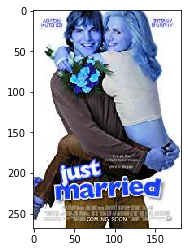

In [158]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X['test_org'], Y['test_org'], predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Drama' 'Romance']
Predicted Labels
['Drama' 'Romance']


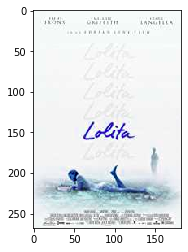

In [159]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X['test_org'], Y['test_org'], predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Horror' 'Comedy']
Predicted Labels
['Comedy' 'Music']


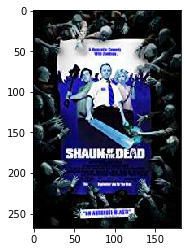

In [160]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X['test_org'], Y['test_org'], predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Family']
Predicted Labels
['Drama']


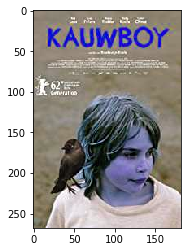

In [161]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X['test_org'], Y['test_org'], predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Adventure' 'Action' 'Thriller' 'Crime']
Predicted Labels
['Comedy' 'Science Fiction']


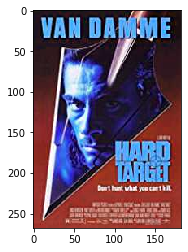

In [162]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X['test_org'], Y['test_org'], predictions['test'], num_samples=1)

Train Data
------------------------------
True Labels
['Horror']
Predicted Labels
['Horror']


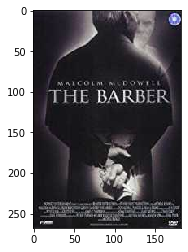

In [163]:
print('Train Data')
print('-' * 30)
predict_random_samples(X['train_org'], Y['train_org'], predictions['train'], num_samples=1)

Train Data
------------------------------
True Labels
['Documentary']
Predicted Labels
['Documentary']


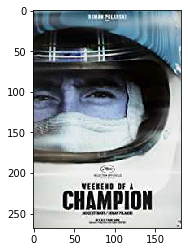

In [164]:
print('Train Data')
print('-' * 30)
predict_random_samples(X['train_org'], Y['train_org'], predictions['train'], num_samples=1)

Train Data
------------------------------
True Labels
['Horror' 'Comedy' 'Thriller']
Predicted Labels
['Horror' 'Thriller']


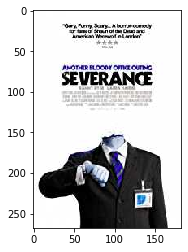

In [165]:
print('Train Data')
print('-' * 30)
predict_random_samples(X['train_org'], Y['train_org'], predictions['train'], num_samples=1)

Train Data
------------------------------
True Labels
['Drama']
Predicted Labels
['Drama']


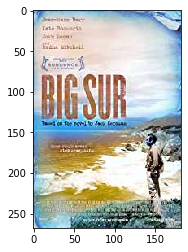

In [166]:
print('Train Data')
print('-' * 30)
predict_random_samples(X['train_org'], Y['train_org'], predictions['train'], num_samples=1)

Train Data
------------------------------
True Labels
['Drama' 'Thriller' 'War']
Predicted Labels
['Drama']


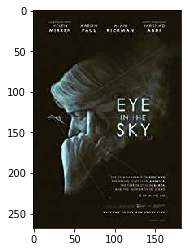

In [167]:
print('Train Data')
print('-' * 30)
predict_random_samples(X['train_org'], Y['train_org'], predictions['train'], num_samples=1)

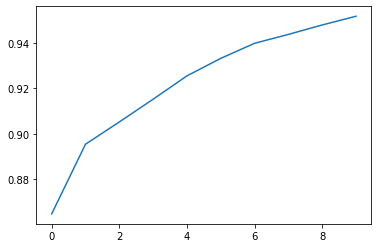

In [168]:
plt.plot(history.history['accuracy'])

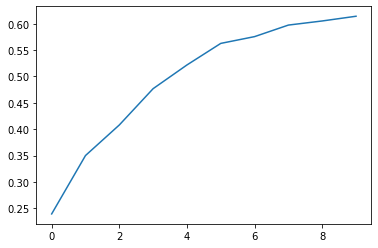

In [169]:
plt.plot(history.history['categorical_accuracy'])

Text(0, 0.5, 'Binary Cross-Entropy Loss')

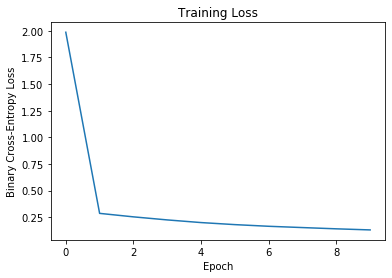

In [171]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')